# **QE: stochastic neoclassical growth model**

Dong Gyun Ko <br>

last updated: september 15, 2023 <br>

In [49]:
# install libraries

!pip install quantecon
!pip install interpolation

In [50]:
# import libraries

import numpy as np
from scipy import linalg as la
from scipy import stats as st

from time import time

import quantecon as qe

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import seaborn as sns

<ipython-input-50-f4ae65f1bf36>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# **question 1**

consider a standard neoclassical growth model. the agent maximizes the following expected utility function:

$\mathbb{E}[\sum_{t=0}^{\infty}\beta^{t}u(c_{t})]$

subjec to

(1) $c_{t}+k_{t+1}-(1-\delta)k_{t}\le y_{t}$,

(2) $y_{t}=e^{z_{t}}f(k_{t})$,

(3) $0\le c_{t} \le y_{t}$ for all $t$,

(4) $u(c)=log(c)$,

(5) $f(k)=k^{\alpha}$.

let assume that productivity process follows AR(1) process where $z_{t+1}=\mu_{z}+\rho z_{t}+\epsilon_{t+1}$, $\epsilon\sim i.i.d. N(0,\sigma_{\epsilon}^{2})$.

suppose $\alpha$ = 1/3, $\beta$ = 0.95, $\delta$ = 0.07, $\rho$ = 0.90, $\sigma_{\epsilon}$ =
0.03, $\mu_{z}$ = 0.

set the number of grid points for capital and productivity as 50,000 and 5, respectively.

(a) write down the Bellman equation. $k_{t+1}$ is a control variable. $k_{t}$ and $z_{t}$ are state variables.

$V(k_{t}, z_{t})=max_{c_{t}, k_{t+1}}{log(c_{t})+βE\big[V(k_{t+1}, z_{t+1})\big]}$

(b) derive the Euler equation. show your work.

let assume that full depreciation is satisfied ($\delta=1$).

$\mathcal{L}=\sum_{t=0}^{\infty}\beta^{t}u(c_{t})+\mu\big[\sum_{t=0}^{\infty}(e^{z_{t}}k_{t}^{\alpha}-c_{t}-k_{t+1})\big]$

FOC w.r.t $c_{t}$, $c_{t+1}$, $k_{t+1}$

$c_{t}$: $\beta^{t}\frac{1}{c_{t}}=\mu$ ... eq.1

$c_{t+1}$: $\beta^{t+1}\frac{1}{c_{t+1}}=\mu$ ... eq.2

$k_{t+1}$: $\alpha e^{z_{t+1}}k_{t+1}^{\alpha-1}=1$ ...eq.3

combining eq.1-3, we can yield the Euler equation as below.

$\frac{1}{c_{t}}=\beta\;\mathbb{E_{t+1}}[\frac{1}{c_{t+1}}\alpha e^{z_{t+1}}k_{t+1}^{\alpha-1}]$ ... eq.4

(c) derive steady state formula of $c_{t}$, $y_{t}$, and $k_{t}$. show your work.

using eq.1, eq.2, and eq.4,

$k_{t+1}=\alpha\beta e^{z_{t}}k_{t}^{\alpha}$

using the constraint (1),

$c_{t}=(1-\alpha\beta)e^{z_{t}}k_{t}^{\alpha}$

thus, we can find steady state for each variable as below.

$k=(\alpha\beta)^\frac{1}{1-\alpha}$

$c=(\alpha\beta)^\frac{\alpha}{1-\alpha}-(\alpha\beta)^\frac{1}{1-\alpha}$

$z=0$

(d) solve the model using the standard value function iteration (VFI). plot relevant policy functions and value functions.

In [51]:
# tauchen function

def tauchen(n, m, mu, rho, sigma):

    sMax = m * sigma
    S, step = np.linspace(-sMax, sMax, num=n, retstep=True)
    x = S - rho * S.reshape((-1, 1)) + step/2
    Pi = st.norm.cdf(x / sigma)
    Pi[:, -1] = 1.
    Pi[:, 1:] = np.diff(Pi)
    S += mu  # centering around unconditional mean

    return S, Pi

In [52]:
# rouwenhorst function

def rouwenhorst(n, mu, rho, sigma):

    def compute_P(p, n):

        if n == 2:
            P = np.array([[p, 1-p], [1-p, p]], dtype=float)

        else:
            Q = compute_P(p, n-1)
            A = np.zeros((n, n))
            B = np.zeros((n, n))
            A[:n-1, :n-1] += Q
            A[1:n, 1:n] += Q
            B[:n-1, 1:n] += Q
            B[1:n, :n-1] += Q
            P = p * A + (1-p) * B
            P[1:-1, :] /= 2

        return P

    p = (1 + rho) / 2
    Pi = compute_P(p, n)
    f = np.sqrt(n-1) * (sigma / np.sqrt(1 - rho**2))
    S = np.linspace(-f, f, n) + mu

    return S, Pi

In [53]:
# set parameter

alpha = 1/3
beta = 0.95
delta = 0.07
mu = 0.00
rho = 0.90
sigma = 0.03

In [54]:
# utility function

u = lambda c : np.log(c)

In [55]:
# capital

# num of grid points for capital
Nk = 1000

# capital maximum
k_max = 10

# capital steady state
k_dss = ((1 - (1-delta) * beta) / (alpha * beta)) ** (1 / (alpha-1))
# k_lo, k_hi = np.array([0.1, 2.5]) * k_dss

# capital grid
K = np.linspace(1e-5, k_max, num=Nk)

In [56]:
# productivity

# num of grid points for productivity
Na = 5

# tauchen (quantecon)
mc = qe.tauchen(5, rho, sigma, mu, n_std=3)
A, P = mc.state_values, mc.P
A = np.exp(A)

"""
# tauchen
m = 0
A, P = tauchen(Na, m, mu, rho, sigma)
A = np.exp(A)

# rouwenhorst
A, P = rouwenhorst(Na, mu, rho, sigma)
A = np.exp(A)
"""

print('low productivity: exp(a) = {:.3f}\n'.format(A[0]) +
      'high productivity: exp(a) = {:.3f}\n'.format(A[-1]) +
      'average productivity: exp(a) = {:.3f}'.format(np.exp(mu + sigma**2/2)))

low productivity: exp(a) = 0.813
high productivity: exp(a) = 1.229
average productivity: exp(a) = 1.000


In [57]:
# standard value function iteration (VFI)

U = np.zeros((Nk, Na))
V0 = np.zeros((Nk, Na))
V1 = np.zeros((Nk, Na))
DRk = np.zeros((Nk, Na), dtype=int)

criterion = 1.0
tolerance = 1e-6
n_iter = 0

standard_VFI_t0 = time()

while criterion > tolerance:

      n_iter += 1

      for i in range(Nk):

          for j in range(Na):

              C = A[j] * K[i]**alpha + (1 - delta) * K[i] - K
              C[C < 0] = np.nan
              U[:, j] = u(C)

          objective = U + beta * V0 @ P.T

          V1[i, :] = np.nanmax(objective, axis=0)
          DRk[i, :] = np.nanargmax(objective, axis=0)

      criterion = np.max(np.abs(V1 - V0))

      V0[:] = V1

standard_VFI_t1 = time()

K1 = K[DRk]
C = np.zeros((Nk, Na))

for j in range(Na):

    C[:, j] = A[j] * K**alpha + (1 - delta) * K - K1[:, j]

k_ss = np.zeros((Na,))

for a in range(Na):

    k_ss[a] = K[np.abs(K - K1[:, a].reshape((-1, ))).argmin()]

<ipython-input-64-0242ef29e41e>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot2grid(pltgrid, (0, 0), rowspan=2)


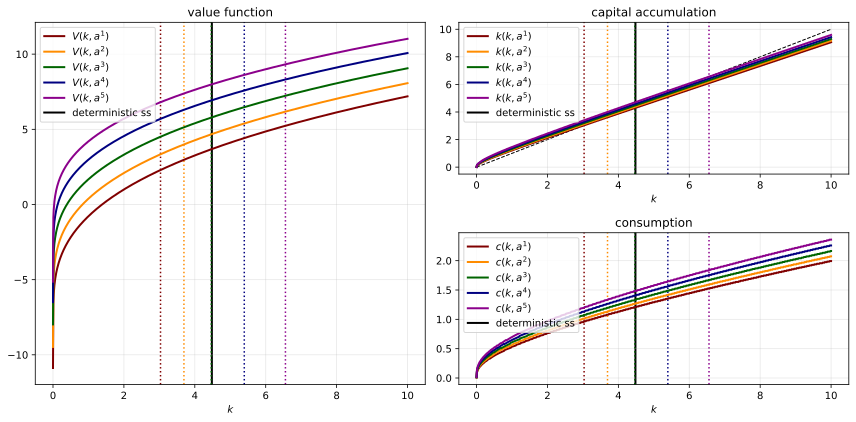

In [64]:
colorstate = ['maroon', 'darkorange', 'darkgreen', 'navy', 'darkmagenta']
V_labels = [r'$V(k, a^1)$', r'$V(k, a^2)$', r'$V(k, a^3)$', r'$V(k, a^4)$', r'$V(k, a^5)$']
C_labels = [r'$c(k, a^1)$', r'$c(k, a^2)$', r'$c(k, a^3)$', r'$c(k, a^4)$', r'$c(k, a^5)$']
K_labels = [r'$k(k, a^1)$', r'$k(k, a^2)$', r'$k(k, a^3)$', r'$k(k, a^4)$', r'$k(k, a^5)$']

fig = plt.subplots(figsize=(12, 6))

ax = [None] * 3

pltgrid = (2, 2)
ax[0] = plt.subplot2grid(pltgrid, (0, 0), rowspan=2)
ax[1] = plt.subplot2grid(pltgrid, (0, 1))
ax[2] = plt.subplot2grid(pltgrid, (1, 1))

for a in range(Na):

    ax[0].plot(K, V1[:, a], linewidth=2, color=colorstate[a], label=V_labels[a])
    ax[1].plot(K, K1[:, a], linewidth=2, color=colorstate[a], label=K_labels[a])
    ax[2].plot(K, C[:, a], linewidth=2, color=colorstate[a], label=C_labels[a])

ax[1].plot(K, K, linewidth=1, color='black', linestyle='dashed', zorder=1)

ax[0].set_title('value function')
ax[1].set_title('capital accumulation')
ax[2].set_title('consumption')

for a in range(3):
    ax[a].axvline(k_dss, color='black', linestyle='solid', lw=2, label='deterministic ss', zorder=1)

    ax[a].axvline(k_ss[0], color=colorstate[0], linestyle='dotted', zorder=1)
    ax[a].axvline(k_ss[1], color=colorstate[1], linestyle='dotted', zorder=1)
    ax[a].axvline(k_ss[2], color=colorstate[2], linestyle='dotted', zorder=1)
    ax[a].axvline(k_ss[3], color=colorstate[3], linestyle='dotted', zorder=1)
    ax[a].axvline(k_ss[4], color=colorstate[4], linestyle='dotted', zorder=1)
    ax[a].grid(alpha=0.3)
    ax[a].set_xlabel('$k$')

    ax[a].legend(loc='upper left', fontsize=10)

plt.tight_layout()

In [59]:
print('low steady state: k = {:.3f}\n'.format(k_ss[0]) +
      'high steady state: k = {:.3f}\n'.format(k_ss[-1]) +
      'deterministic steady state: k = {:.3f}'.format(k_dss))

low steady state: k = 3.033
high steady state: k = 6.557
deterministic steady state: k = 4.481


(e) compare running time in (d).

In [42]:
print('running time in standard VFI: {} iterations and {} seconds'.format(n_iter, (standard_VFI_t1 - standard_VFI_t0)))

running time in standard VFI: 234 iterations and 54.08682942390442 seconds


# **references**

[1] [github page](https://github.com/fagan2888/numerical_methods_macroeconomics/blob/da98514ba2f9f5282d790dd2071d80f75df03b88/ta_sessions/3_stochastic_methods.ipynb#L17)